# 1차 분류기

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, cross_val_predict
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, classification_report, f1_score
from collections import defaultdict

df = pd.read_csv('./dataset/must_use_final.csv')  
df["TIMESTAMP"] = pd.to_datetime(df["TIMESTAMP"])
df = df.sort_values("TIMESTAMP").reset_index(drop=True)
# 시점 정렬해서 5시간 시점만 추출하기 위해서
max_gap = pd.Timedelta(minutes=10) # 타겟 시점과 실제 데이터 시간의 최대 허용 오차를 10분으로 제한함
time_offsets = [14]  # 선박별로 출항 시점 기준으로 3,5,9 시간 뒤의 위치 데이터를 추출 -> 여기 수정해서 사용 ✅
time_based_data = {hour: [] for hour in time_offsets}  # 각 시간마다 추출된 데이터를 담을 빈 리스트로 시작함

for (vsl_id, port), group in df.groupby(["VSL_ID", "PORT_NAME"]): # 선박과 도착항구의 조합별로 데이터 나눠서 봄
    group = group.sort_values("TIMESTAMP")   # 해당 선박의 데이터를 시간순 정렬
    if group.empty:   # 비어있으면 contimue로 패스
        continue
    start_time = group["TIMESTAMP"].min()   # 출발 시점을 start time 설정
    for hour in time_offsets:
        target_time = start_time + pd.Timedelta(hours=hour)
        time_diff = (group["TIMESTAMP"] - target_time).abs()  # .abs() 절대값
        closest_idx = time_diff.idxmin()    # idxmin(): 가장 작은 차이를 가진 인덱스 추출
        if time_diff[closest_idx] <= max_gap: # max_gap 10 분 보다 시간 차이 크면 무시
            closest_row = group.loc[closest_idx]    # 조건 통과시 row 뽑아서 저장
            time_based_data[hour].append(closest_row) # time_based_data[hour] 여기에 추가
df_5h = pd.DataFrame(time_based_data[14]).reset_index(drop=True)  # 5시간 뒤 시의 데이터만 모음

feature_cols = ['LAT', 'LON', 'COG', 'HEADING']  # 독립 변수
target_col = 'CLUSTER_1'     # 종속변수
X = df_5h[feature_cols].values   # 값만 뽑아내기
y = df_5h[target_col].values
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=42       # stratify=y : 클래스 비율 유지하면서 train/test 분할
)  

# ===== RandomForest 하이퍼파라미터 튜닝 =====
param_grid_rf = {      # 여기서 정의한 값들을 조합해 최적 성능을 내는 조합을 찾는 과정
    'n_estimators': [100, 200],   # 트리 몇 개 만들지 (많을수록 성능 안정)
    'max_depth': [8, 10],       # 각 트리의 최대 깊이 (적절한 깊이가 중요)
    'min_samples_split': [2, 5],   # 노드 분할하기 위해 필요한 최소 샘플 수
    'max_features': ['sqrt', 'log2']   # 각 트리 노드를 분할할 때 몇 개 특성을 고려할지 / 'sqrt': 전체 특성 수의 제곱근 / 'log2': 전체 특성 수의 로그2
}

grid_rf = GridSearchCV(
    estimator=RandomForestClassifier(class_weight='balanced', random_state=42),
    param_grid=param_grid_rf,
    cv=3,
    scoring='accuracy',
    n_jobs=-1
)
grid_rf.fit(X_train, y_train)
best_rf = grid_rf.best_estimator_
print("✅ 최적 RF 파라미터:", grid_rf.best_params_)

# ===== XGBoost 하이퍼파라미터 튜닝 =====
param_grid_xgb = {
    'n_estimators': [100, 200],
    'max_depth': [4, 6],
    'learning_rate': [0.05, 0.1],
    'subsample': [0.8, 1.0]
}
grid_xgb = GridSearchCV(
    estimator=XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42),
    param_grid=param_grid_xgb,
    cv=3,
    scoring='accuracy',
    n_jobs=-1
)
grid_xgb.fit(X_train, y_train)
best_xgb = grid_xgb.best_estimator_
print("✅ 최적 XGB 파라미터:", grid_xgb.best_params_)

# ===== KNN 하이퍼파라미터 튜닝 =====
param_grid_knn = {
    'n_neighbors': [3, 5, 7],
    'weights': ['uniform', 'distance'],
    'p': [1, 2]
}
grid_knn = GridSearchCV(
    estimator=KNeighborsClassifier(),
    param_grid=param_grid_knn,
    cv=3,
    scoring='accuracy',
    n_jobs=-1
)
grid_knn.fit(X_train, y_train)
best_knn = grid_knn.best_estimator_
print("✅ 최적 KNN 파라미터:", grid_knn.best_params_)

# ===== 최적 모델로 소프트 보팅 앙상블 구성 =====
classifier = VotingClassifier(estimators=[
    ('rf', best_rf),
    ('knn', best_knn),
    ('xgb', best_xgb)
], voting='soft')
classifier.fit(X_train, y_train)

y_pred = classifier.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"\n🎯 전체 모델 정확도: {accuracy:.4f}")

class_accuracy = defaultdict(list)
for true_label, pred_label in zip(y_test, y_pred):
    class_accuracy[true_label].append(true_label == pred_label)

print("\n📌 클래스별 정확도 (CLUSTER_1 오름차순):")
for cls in sorted(class_accuracy.keys()):
    acc = np.mean(class_accuracy[cls])
    print(f" - {cls}: {acc:.4f}")

# ===== 정밀도, 재현율, F1-score 출력 =====
print("\n📊 분류 성능 보고서 (classification report):")
print(classification_report(y_test, y_pred, digits=4))

# ===== 교차검증 + macro F1-score 평가 =====
print("\n🔁 [교차검증] 5-Fold 예측 수행 중...")
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
y_pred_cv = cross_val_predict(classifier, X, y, cv=skf)
acc_cv = accuracy_score(y, y_pred_cv)
macro_f1 = f1_score(y, y_pred_cv, average='macro')
weighted_f1 = f1_score(y, y_pred_cv, average='weighted')

print(f"\n✅ [교차검증] 전체 정확도: {acc_cv:.4f}")
print(f"🌍 [교차검증] macro F1-score: {macro_f1:.4f}")
print(f"⚖️ [교차검증] weighted F1-score: {weighted_f1:.4f}\n")

print("📊 [교차검증] classification report:")
print(classification_report(y, y_pred_cv, digits=4))

print("\n📌 [교차검증] CLUSTER_1별 정확도:")
class_accuracy_cv = defaultdict(list)
for true_label, pred_label in zip(y, y_pred_cv):
    class_accuracy_cv[true_label].append(true_label == pred_label)

for cls in sorted(class_accuracy_cv):
    acc = np.mean(class_accuracy_cv[cls])
    print(f" - CLUSTER_1 = {cls}: 정확도 {acc:.4f} ({len(class_accuracy_cv[cls])}개 샘플)")

import joblib
import os

# 모델 저장
joblib.dump(classifier, 'model/cluster_14hours.joblib')

# 인코더 저장
# joblib.dump(le, 'model/encoder_2.joblib')

print("✅ 모델과 인코더가 각각 저장되었습니다.")


✅ 최적 RF 파라미터: {'max_depth': 8, 'max_features': 'sqrt', 'min_samples_split': 2, 'n_estimators': 200}
✅ 최적 XGB 파라미터: {'learning_rate': 0.05, 'max_depth': 4, 'n_estimators': 100, 'subsample': 0.8}
✅ 최적 KNN 파라미터: {'n_neighbors': 7, 'p': 1, 'weights': 'distance'}

🎯 전체 모델 정확도: 0.7886

📌 클래스별 정확도 (CLUSTER_1 오름차순):
 - 0: 0.0000
 - 1: 0.6207
 - 2: 0.7778
 - 3: 1.0000
 - 4: 0.7000
 - 5: 0.0000
 - 6: 0.8824
 - 7: 1.0000

📊 분류 성능 보고서 (classification report):
              precision    recall  f1-score   support

           0     0.0000    0.0000    0.0000         1
           1     0.7826    0.6207    0.6923        29
           2     0.8400    0.7778    0.8077        27
           3     0.8750    1.0000    0.9333        28
           4     0.5385    0.7000    0.6087        10
           5     0.0000    0.0000    0.0000         3
           6     0.7143    0.8824    0.7895        17
           7     1.0000    1.0000    1.0000         8

    accuracy                         0.7886       123
   mac

# 1번군집

In [57]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings("ignore")

from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, cross_val_predict
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import resample
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, classification_report
from sklearn.utils.multiclass import unique_labels
import os

# ===== 1. 데이터 불러오기 및 CLUSTER_1 == 1 필터링 =====
df = pd.read_csv('./dataset/must_use_final.csv')
df["TIMESTAMP"] = pd.to_datetime(df["TIMESTAMP"])
df = df[df["CLUSTER_1"] == 1].copy()
df = df.sort_values("TIMESTAMP").reset_index(drop=True)

# ===== 2. 14시간 시점 기준 추출 =====
time_based_data = []
max_gap = pd.Timedelta(minutes=10)

for (vsl_id, port), group in df.groupby(["VSL_ID", "PORT_NAME"]):
    group = group.sort_values("TIMESTAMP")
    if group.empty: continue
    start_time = group["TIMESTAMP"].min()
    target_time = start_time + pd.Timedelta(hours=14)
    time_diff = (group["TIMESTAMP"] - target_time).abs()
    closest_idx = time_diff.idxmin()
    if time_diff[closest_idx] <= max_gap:
        time_based_data.append(group.loc[closest_idx])

df_14h = pd.DataFrame(time_based_data).reset_index(drop=True)

# ===== 3. Feature & Target 설정 =====
feature_cols = ['LAT', 'LON', 'COG', 'HEADING']
X = df_14h[feature_cols].values
y_raw = df_14h['PORT_NAME'].astype(str)
le = LabelEncoder()
y = le.fit_transform(y_raw)

# ===== 3.5. 클래스가 2개 미만인 라벨 제거 =====
from collections import Counter
label_counts = Counter(y)
valid_labels = [label for label, count in label_counts.items() if count > 3]
valid_mask = np.isin(y, valid_labels)
X = X[valid_mask]
y = y[valid_mask]

# ===== 4. Train/Test 분리 =====
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# ===== 5. 오버샘플링 (Train만 적용) =====
train_df = pd.DataFrame(X_train, columns=feature_cols)
train_df['label'] = y_train
max_count = train_df['label'].value_counts().max()

oversampled = []
for label in train_df['label'].unique():
    subset = train_df[train_df['label'] == label]
    if len(subset) < max_count:
        upsampled = resample(subset, replace=True, n_samples=max_count - len(subset), random_state=42)
        oversampled.append(pd.concat([subset, upsampled]))
    else:
        oversampled.append(subset)

balanced_df = pd.concat(oversampled).sample(frac=1, random_state=42)
X_train_bal = balanced_df[feature_cols].values
y_train_bal = balanced_df['label'].values

# ===== 6. 저장 =====
np.save("datasets/x_train_c1_14hours.npy", X_train_bal)
np.save("datasets/x_test_c1_14hours.npy", X_test)
np.save("datasets/y_train_c1_14hours.npy", y_train_bal)
np.save("datasets/y_test_c1_14hours.npy", y_test)
print("✅ 학습 및 테스트 데이터셋 저장 완료!")

# ===== 7. 모델별 하이퍼파라미터 튜닝 =====
# RandomForest
param_grid_rf = {
    'n_estimators': [200, 300],          # 트리 수 증가 → 안정화
    'max_depth': [6, 10],           # 트리 깊이 증가 → 복잡성 허용
    'min_samples_split': [2],       # 분할 최소 샘플 수 감소 → 세분화
    'max_features': ['sqrt'],       # 그대로 유지
    'class_weight': ['balanced']    # 클래스 불균형 고려
}
grid_rf = GridSearchCV(RandomForestClassifier(random_state=42),
                       param_grid_rf, cv=3, n_jobs=-1)
grid_rf.fit(X_train, y_train)
best_rf = grid_rf.best_estimator_

# LogisticRegression
param_grid_lr = {
    'C': [1.0, 5.0, 10.0],           # 정규화 감소 → 과적합 조절
    'solver': ['liblinear'],
    'penalty': ['l2'],
    'class_weight': ['balanced']
}
grid_lr = GridSearchCV(LogisticRegression(max_iter=1000, random_state=42),
                       param_grid_lr, cv=3, n_jobs=-1)
grid_lr.fit(X_train, y_train)
best_lr = grid_lr.best_estimator_

# ===== 8. 소프트 보팅 앙상블 모델 학습 =====
classifier = VotingClassifier(estimators=[
    ('rf', best_rf),
    ('lr', best_lr)
], voting='soft')
classifier.fit(X_train_bal, y_train_bal)

# ===== 9. 과적합 점검 =====
y_train_pred = classifier.predict(X_train_bal)
y_test_pred = classifier.predict(X_test)

print("\n📌 [과적합 점검]")
print(f"Train Accuracy : {accuracy_score(y_train_bal, y_train_pred):.4f}")
print(f"Test Accuracy  : {accuracy_score(y_test, y_test_pred):.4f}")
print(f"Accuracy Gap   : {accuracy_score(y_train_bal, y_train_pred) - accuracy_score(y_test, y_test_pred):.4f}")

# ===== 10. 테스트셋 classification report (유효 라벨만) =====
labels_test = unique_labels(y_test, y_test_pred)
print("\n📘 [Test Set Classification Report]")
print(classification_report(
    y_test, y_test_pred,
    labels=labels_test,
    target_names=le.inverse_transform(labels_test),
    digits=4
))

# ===== 11. 교차검증 평가 =====
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
y_pred_cv = cross_val_predict(classifier, X_train_bal, y_train_bal, cv=skf)

cv_acc = accuracy_score(y_train_bal, y_pred_cv)
cv_f1_macro = f1_score(y_train_bal, y_pred_cv, average='macro')
cv_f1_weighted = f1_score(y_train_bal, y_pred_cv, average='weighted')

labels_cv = unique_labels(y_train_bal, y_pred_cv)
print("\n🔁 [5-Fold 교차검증 성능]")
print(f"CV Accuracy        : {cv_acc:.4f}")
print(f"CV F1-score (Macro): {cv_f1_macro:.4f}")
print(f"CV F1-score (Wgt)  : {cv_f1_weighted:.4f}")

print("\n📊 [5-Fold Classification Report]")
print(classification_report(
    y_train_bal, y_pred_cv,
    labels=labels_cv,
    target_names=le.inverse_transform(labels_cv),
    digits=4
))

# ===== 12. 유효하지 않은 라벨 목록 출력 =====
from collections import Counter

# 전체 라벨 목록
all_labels = np.arange(len(le.classes_))

# 실제 사용된 라벨만 필터링된 라벨 목록
used_labels = np.unique(y)

# 유효하지 않은 (데이터 개수 1개 이하) 라벨 식별
label_counts_total = Counter(y_raw)
invalid_labels = [label for label, count in label_counts_total.items() if count < 3]

print("\n🚫 [유효하지 않은 라벨 목록 (데이터 2개 미만)]")
for label in invalid_labels:
    print(f" - {label} (count={label_counts_total[label]})")

✅ 학습 및 테스트 데이터셋 저장 완료!

📌 [과적합 점검]
Train Accuracy : 0.9565
Test Accuracy  : 0.6667
Accuracy Gap   : 0.2899

📘 [Test Set Classification Report]
              precision    recall  f1-score   support

       JPHIJ     1.0000    1.0000    1.0000         2
       KRINC     0.6000    0.5000    0.5455         6
       KRKAN     0.8000    1.0000    0.8889         4
       KRPTK     0.0000    0.0000    0.0000         2
       KRYOS     1.0000    0.7500    0.8571         4

    accuracy                         0.6667        18
   macro avg     0.6800    0.6500    0.6583        18
weighted avg     0.7111    0.6667    0.6809        18


🔁 [5-Fold 교차검증 성능]
CV Accuracy        : 0.8435
CV F1-score (Macro): 0.8399
CV F1-score (Wgt)  : 0.8399

📊 [5-Fold Classification Report]
              precision    recall  f1-score   support

       JPHIJ     1.0000    1.0000    1.0000        23
       KRINC     0.8235    0.6087    0.7000        23
       KRKAN     0.8261    0.8261    0.8261        23
       KRPTK 

In [59]:
import joblib
import os

# 모델 저장
joblib.dump(classifier, 'model/port_c1_14hours.joblib')

# 인코더 저장
joblib.dump(le, 'model/encoder_c1_14hours.joblib')

print("✅ 모델과 인코더가 각각 저장되었습니다.")

✅ 모델과 인코더가 각각 저장되었습니다.


# 2번 군집

✅ 학습 및 테스트 데이터셋 저장 완료!


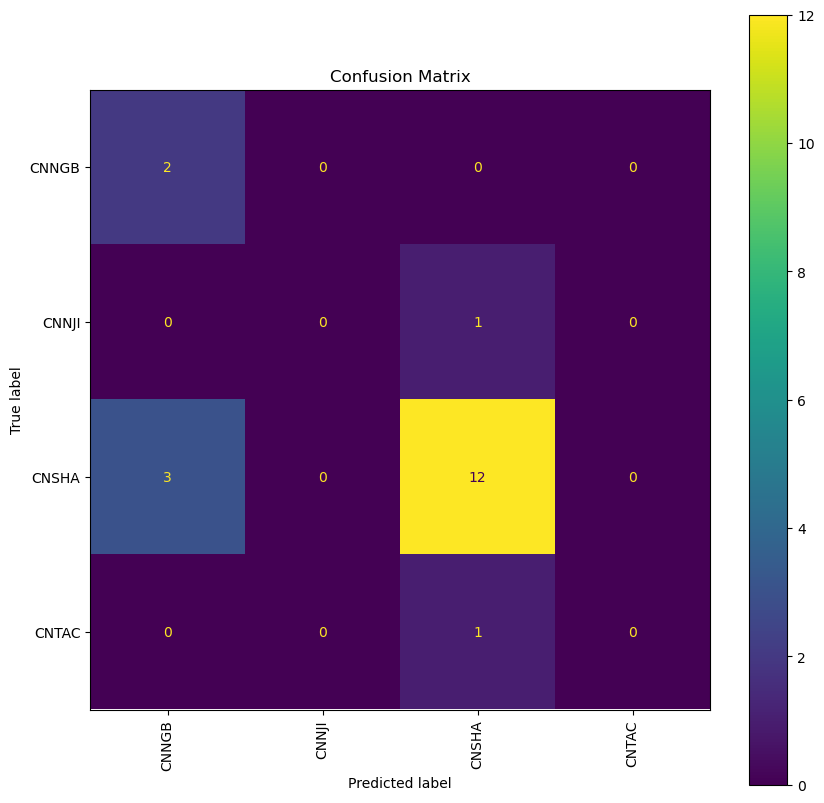


📊 [교차검증 및 과적합 점검 결과]
학습 정확도              : 0.8611
테스트 정확도            : 0.7368
정확도 차이              : 0.1243 ⚠️ 과적합 의심
교차검증 평균 정확도     : 0.7800 ± 0.0734
교차검증 F1 매크로 평균  : 0.4467
교차검증 정밀도 평균     : 0.4250

📄 [Classification Report]
              precision    recall  f1-score   support

       CNNGB       0.40      1.00      0.57         2
       CNNJI       0.00      0.00      0.00         1
       CNSHA       0.86      0.80      0.83        15
       CNTAC       0.00      0.00      0.00         1

    accuracy                           0.74        19
   macro avg       0.31      0.45      0.35        19
weighted avg       0.72      0.74      0.71        19



In [63]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import resample
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.metrics import classification_report, accuracy_score, f1_score, precision_score, confusion_matrix, ConfusionMatrixDisplay
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
import os

# ===== 1. 데이터 불러오기 및 CLUSTER_1 == 2 필터링 =====
df = pd.read_csv('./dataset/must_use_final.csv')
df["TIMESTAMP"] = pd.to_datetime(df["TIMESTAMP"])
df = df[df["CLUSTER_1"] == 2].copy() # 여기 수정
df = df.sort_values("TIMESTAMP").reset_index(drop=True)

# ===== 2. 14시간 시점 기준 추출 =====
time_based_data = []
max_gap = pd.Timedelta(minutes=10)

for (vsl_id, port), group in df.groupby(["VSL_ID", "PORT_NAME"]):
    group = group.sort_values("TIMESTAMP")
    if group.empty: continue
    start_time = group["TIMESTAMP"].min()
    target_time = start_time + pd.Timedelta(hours=14) # 여기 수정
    time_diff = (group["TIMESTAMP"] - target_time).abs()
    closest_idx = time_diff.idxmin()
    if time_diff[closest_idx] <= max_gap:
        time_based_data.append(group.loc[closest_idx])

df_14h = pd.DataFrame(time_based_data).reset_index(drop=True)


# ===== 2. 피처 및 라벨 인코딩 =====
features = ["LAT", "LON", "COG", "HEADING"]
X = df_14h[features]         # ✅ 수정
y = df_14h["PORT_NAME"]      # ✅ 수정
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# ===== 3. 학습/테스트 분리 =====
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, stratify=y_encoded, random_state=42
)

# ===== 4. 클래스별 오버샘플링 (Train만) =====
class_counts = pd.Series(y_train).value_counts()
max_count = class_counts.max()
minority_classes = class_counts[class_counts < max_count * 1.5].index

# 원하는 샘플링 비율 지정
sampling_ratios = {
    0: 2.0,
    1: 2.5,
    2: 1.0,
    3: 2.5
}

resampled_X = []
resampled_y = []

for label in minority_classes:
    subset_X = X_train[y_train == label]
    subset_y = y_train[y_train == label]
    
    n_samples = int(len(subset_X) * sampling_ratios.get(label, 1.0))
    
    up_X = resample(subset_X, replace=True, n_samples=n_samples, random_state=42)
    up_y = np.full(n_samples, label)
    
    resampled_X.append(up_X)
    resampled_y.append(up_y)

X_train_resampled = np.vstack(resampled_X)
y_train_resampled = np.hstack(resampled_y)

# ===== 5. 모델 정의 및 학습 (하이퍼파라미터 조정 포함) =====
rf = RandomForestClassifier(
    class_weight='balanced',
    n_estimators=50,
    max_depth=5,
    min_samples_leaf=5,
    random_state=42
)

xgb = XGBClassifier(
    n_estimators=50,
    max_depth=3,
    learning_rate=0.05,
    reg_alpha=0.5,
    reg_lambda=1.0,
    use_label_encoder=False,
    eval_metric='mlogloss',
    random_state=42
)

voting_clf = VotingClassifier(
    estimators=[('rf', rf), ('xgb', xgb)],
    voting='soft'
)

voting_clf.fit(X_train_resampled, y_train_resampled)

# ===== 6. 평가 =====
y_pred = voting_clf.predict(X_test)
report = classification_report(y_test, y_pred, target_names=le.classes_)

# ===== 7. 저장 =====

np.save("datasets/X_train_c2_14hours.npy", X_train_resampled)
np.save("datasets/X_test_c2_14hours.npy", X_test)
np.save("datasets/y_train_c2_14hours.npy", y_train_resampled)
np.save("datasets/y_test_c2_14hours.npy", y_test)
print("✅ 학습 및 테스트 데이터셋 저장 완료!")

# ===== 8. 교차검증 =====
acc_scores = cross_val_score(voting_clf, X_train, y_train, cv=5, scoring='accuracy')
f1_scores = cross_val_score(voting_clf, X_train, y_train, cv=5, scoring='f1_macro')
prec_scores = cross_val_score(voting_clf, X_train, y_train, cv=5, scoring='precision_macro')

# ===== 9. 과적합 점검 =====
train_score = voting_clf.score(X_train, y_train)
test_score = voting_clf.score(X_test, y_test)
gap = train_score - test_score

# ===== 10. Confusion Matrix 시각화 =====
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_)
fig, ax = plt.subplots(figsize=(10, 10))
disp.plot(ax=ax, xticks_rotation=90)
plt.title("Confusion Matrix")
plt.grid(False)
plt.show()

# ===== 11. 출력 =====
print("\n📊 [교차검증 및 과적합 점검 결과]")
print(f"학습 정확도              : {train_score:.4f}")
print(f"테스트 정확도            : {test_score:.4f}")
print(f"정확도 차이              : {gap:.4f} {'⚠️ 과적합 의심' if gap > 0.1 else '과적합 위험 없음'}")
print(f"교차검증 평균 정확도     : {acc_scores.mean():.4f} ± {acc_scores.std():.4f}")
print(f"교차검증 F1 매크로 평균  : {f1_scores.mean():.4f}")
print(f"교차검증 정밀도 평균     : {prec_scores.mean():.4f}")
print("\n📄 [Classification Report]")
print(report)


In [65]:
import joblib
import os

# 모델 저장
joblib.dump(voting_clf, 'model/port_c2_14hours.joblib')

# 인코더 저장
joblib.dump(le, 'model/encoder_c2_14hours.joblib')

print("✅ 모델과 인코더가 각각 저장되었습니다.")

✅ 모델과 인코더가 각각 저장되었습니다.


# 3번 군집

🔍 Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.81      0.81        16
           1       0.75      0.75      0.75        12

    accuracy                           0.79        28
   macro avg       0.78      0.78      0.78        28
weighted avg       0.79      0.79      0.79        28

📊 Confusion Matrix:


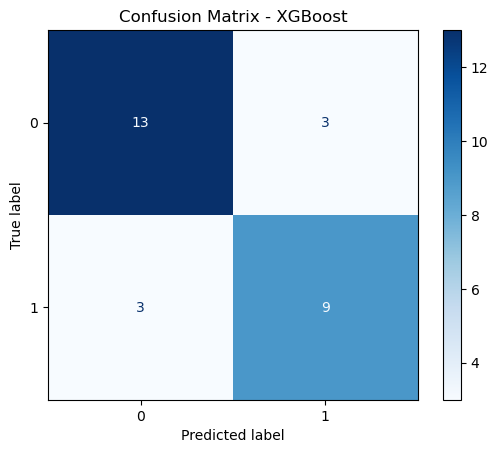


✅ 5-Fold 교차검증 정확도 평균: 0.7692 ± 0.0843

📈 Train Accuracy: 0.9385
📉 Test Accuracy : 0.7857
🔍 학습 정확도와 테스트 정확도의 차이: 0.1527


In [128]:
import pandas as pd
import numpy as np
from datetime import timedelta
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

# ===== 1. 데이터 불러오기 =====
df = pd.read_csv('cluster_3_mapped_V2.csv')
df['TIMESTAMP'] = pd.to_datetime(df['TIMESTAMP'])
df = df.sort_values(by=['VSL_ID', 'PORT_NAME', 'TIMESTAMP']).reset_index(drop=True)

# ===== 2. 출발 5시간 시점 데이터 추출 =====
rows_5h = []
for (vsl_id, port), group in df.groupby(['VSL_ID', 'PORT_NAME']):
    group = group.sort_values('TIMESTAMP')
    if len(group) >= 84:  # 10분 단위 30개 = 5시간
        row_5h = group.iloc[83]
        rows_5h.append(row_5h)

df_5h = pd.DataFrame(rows_5h).dropna(subset=["LAT", "LON", "COG", "HEADING"])

# ===== 3. 특성과 타겟 분리 =====
# PORT_NAME 기준으로 라벨 인코딩
le = LabelEncoder()
df_5h['CLUSTER_2'] = le.fit_transform(df_5h['PORT_CLUSTER'])
#df['CLUSTER_2'].value_counts()

features = ["LAT", "LON", "COG", "HEADING"]
X = df_5h[features].values
y = df_5h["CLUSTER_2"].values

# ===== 4. 학습/테스트 분리 =====
X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.3, random_state=42
)

np.save("datasets/X_train_c3_14hours.npy", X_train)
np.save("datasets/X_test_c3_14hours.npy", X_test)
np.save("datasets/y_train_c3_14hours.npy", y_train)
np.save("datasets/y_test_c3_14hours.npy", y_test)

# ===== 5. 모델 정의 (과적합 완화 설정) =====
model = XGBClassifier(
    max_depth=3,           # 과적합 방지용 depth 제한
    n_estimators=100,      # 트리 개수 줄이기
    subsample=0.8,         # 데이터 샘플 비율
    colsample_bytree=0.8,  # 특성 샘플 비율
    learning_rate=0.1,
    random_state=42,
    use_label_encoder=False,
    eval_metric='mlogloss'
)

# ===== 6. 모델 학습 =====
model.fit(X_train, y_train)

# ===== 7. 예측 및 평가 =====
y_pred = model.predict(X_test)

print("🔍 Classification Report:")
print(classification_report(y_test, y_pred))

print("📊 Confusion Matrix:")
ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred)).plot(cmap='Blues')
plt.title("Confusion Matrix - XGBoost")
plt.show()

# ===== 8. 교차검증 =====
cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy')
print(f"\n✅ 5-Fold 교차검증 정확도 평균: {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")

# ===== 9. 과적합 여부 확인 =====
train_acc = accuracy_score(y_train, model.predict(X_train))
test_acc = accuracy_score(y_test, y_pred)
print(f"\n📈 Train Accuracy: {train_acc:.4f}")
print(f"📉 Test Accuracy : {test_acc:.4f}")
print(f"🔍 학습 정확도와 테스트 정확도의 차이: {round(train_acc - test_acc, 4)}")

In [130]:
import joblib
import os

# 모델 저장
joblib.dump(model, 'model/port_c3_14hours.joblib')

# 인코더 저장
joblib.dump(le, 'model/encoder_c3_14hours.joblib')

print("✅ 모델과 인코더가 각각 저장되었습니다.")

✅ 모델과 인코더가 각각 저장되었습니다.


# 4번 군집

✅ Best XGBoost: {'colsample_bytree': 0.8, 'learning_rate': 0.05, 'max_depth': 2, 'n_estimators': 50, 'reg_alpha': 0.5, 'reg_lambda': 1.0, 'subsample': 1.0}
✅ Best LogisticRegression: {'C': 10.0, 'class_weight': None, 'penalty': 'l2', 'solver': 'lbfgs'}

📊 [앙상블 성능 평가 및 과적합 진단]
Train Accuracy           : 0.7917
Test Accuracy            : 0.4286
Accuracy Gap             : 0.3631 ⚠️ 과적합 의심
Train F1-score (macro)   : 0.7831
Test F1-score (macro)    : 0.4583
CV Accuracy Mean         : 0.3810 ± 0.0987
CV F1-score Mean         : 0.2769
CV Precision Mean        : 0.2617

📄 [Classification Report]
              precision    recall  f1-score   support

       CNHUA       0.50      0.50      0.50         2
       HKHKG       0.00      0.00      0.00         2
       TWKEL       1.00      0.50      0.67         2
       TWKHH       0.50      1.00      0.67         1

    accuracy                           0.43         7
   macro avg       0.50      0.50      0.46         7
weighted avg       0.50  

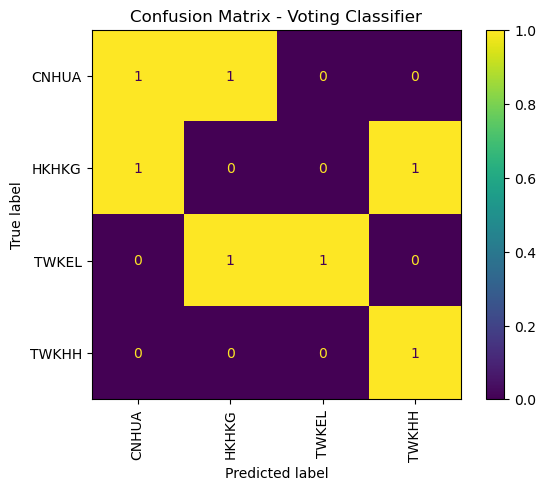

In [136]:
import pandas as pd
import numpy as np
from datetime import timedelta
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import resample
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    precision_score,
    classification_report,
    make_scorer,
    ConfusionMatrixDisplay
)
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

# ===== 1. 데이터 불러오기 및 CLUSTER_1 == 4 필터링 =====
df = pd.read_csv('./dataset/must_use_final.csv')  # 직접 경로 수정 가능
df["TIMESTAMP"] = pd.to_datetime(df["TIMESTAMP"])
df = df[df["CLUSTER_1"] == 4].copy()
df = df.sort_values("TIMESTAMP").reset_index(drop=True)

# ===== 2. 14시간 시점 기준 추출 (같은 선박이더라도 PORT_NAME 다르면 다르게 그룹화) =====
time_based_data = []
max_gap = pd.Timedelta(minutes=10)
for (vsl_id, port), group in df.groupby(["VSL_ID", "PORT_NAME"]):
    group = group.sort_values("TIMESTAMP")
    if group.empty:
        continue
    start_time = group["TIMESTAMP"].min()
    target_time = start_time + pd.Timedelta(hours=14)
    time_diff = (group["TIMESTAMP"] - target_time).abs()
    closest_idx = time_diff.idxmin()
    if time_diff[closest_idx] <= max_gap:
        time_based_data.append(group.loc[closest_idx])
df_14h = pd.DataFrame(time_based_data).reset_index(drop=True)

# ===== 3. 피처 및 라벨 인코딩 =====
features = ["LAT", "LON", "COG", "HEADING"]
df_14h = df_14h.dropna(subset=features + ["PORT_NAME"])
le = LabelEncoder()
df_14h["label"] = le.fit_transform(df_14h["PORT_NAME"])  # 숫자로 바꾼 종속변수

# ===== 4. 오버샘플링 (train만 적용) =====
X = df_14h[features]
y = df_14h["label"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# 클래스별로 max의 1.5배까지 증강
train_df = pd.concat([X_train, y_train], axis=1)
oversampled_rows = []
target_size = int(train_df["label"].value_counts().max() * 1.5)

for label in train_df["label"].unique():
    subset = train_df[train_df["label"] == label]
    if len(subset) < target_size:
        upsampled = resample(subset, replace=True, n_samples=target_size, random_state=42)
        oversampled_rows.append(upsampled)
    else:
        oversampled_rows.append(subset)

resampled_train = pd.concat(oversampled_rows).reset_index(drop=True)
X_train = resampled_train[features]
y_train = resampled_train["label"]

np.save("datasets/X_train_c4_14hours.npy", X_train)
np.save("datasets/X_test_c4_14hours.npy", X_test)
np.save("datasets/y_train_c4_14hours.npy", y_train)
np.save("datasets/y_test_c4_14hours.npy", y_test)

# ===== 5. 모델 정의 및 하이퍼파라미터 튜닝 =====
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42)
xgb_param_grid = {
    'max_depth': [2, 3],
    'n_estimators': [50],
    'learning_rate': [0.05],
    'reg_alpha': [0.5],
    'reg_lambda': [1.0],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}
xgb_grid = GridSearchCV(xgb_model, xgb_param_grid, cv=3, scoring='accuracy', n_jobs=-1)
xgb_grid.fit(X_train, y_train)
best_xgb = xgb_grid.best_estimator_

lr_model = LogisticRegression(max_iter=500)
lr_param_grid = {
    'C': [0.01, 0.1, 1.0, 10.0],
    'solver': ['liblinear', 'lbfgs'],
    'penalty': ['l2'],
    'class_weight': [None, 'balanced']
}
lr_grid = GridSearchCV(lr_model, lr_param_grid, cv=3, scoring='accuracy', n_jobs=-1)
lr_grid.fit(X_train, y_train)
best_lr = lr_grid.best_estimator_

# ===== 6. 소프트 보팅 앙상블 =====
voting_clf = VotingClassifier(
    estimators=[('xgb', best_xgb), ('lr', best_lr)],
    voting='soft',
    weights=[1, 2]
)
voting_clf.fit(X_train, y_train)

# ===== 7. 평가 =====
y_train_pred = voting_clf.predict(X_train)
y_test_pred = voting_clf.predict(X_test)

train_acc = accuracy_score(y_train, y_train_pred)
test_acc = accuracy_score(y_test, y_test_pred)
gap = train_acc - test_acc
train_f1 = f1_score(y_train, y_train_pred, average='macro')
test_f1 = f1_score(y_test, y_test_pred, average='macro')

# ===== 8. 교차검증 =====
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_acc = cross_val_score(voting_clf, X, y, cv=skf, scoring='accuracy')
cv_f1 = cross_val_score(voting_clf, X, y, cv=skf, scoring=make_scorer(f1_score, average='macro'))
cv_prec = cross_val_score(voting_clf, X, y, cv=skf, scoring=make_scorer(precision_score, average='macro'))

# ===== 9. 결과 출력 =====
print("✅ Best XGBoost:", xgb_grid.best_params_)
print("✅ Best LogisticRegression:", lr_grid.best_params_)
print("\n📊 [앙상블 성능 평가 및 과적합 진단]")
print(f"Train Accuracy           : {train_acc:.4f}")
print(f"Test Accuracy            : {test_acc:.4f}")
print(f"Accuracy Gap             : {gap:.4f} {'⚠️ 과적합 의심' if gap > 0.1 else '✅ 과적합 위험 없음'}")
print(f"Train F1-score (macro)   : {train_f1:.4f}")
print(f"Test F1-score (macro)    : {test_f1:.4f}")
print(f"CV Accuracy Mean         : {cv_acc.mean():.4f} ± {cv_acc.std():.4f}")
print(f"CV F1-score Mean         : {cv_f1.mean():.4f}")
print(f"CV Precision Mean        : {cv_prec.mean():.4f}")
print("\n📄 [Classification Report]")
print(classification_report(y_test, y_test_pred, target_names=le.classes_))

ConfusionMatrixDisplay.from_estimator(voting_clf, X_test, y_test, display_labels=le.classes_, xticks_rotation=90)
plt.title("Confusion Matrix - Voting Classifier")
plt.show()


In [113]:
import joblib
import os

# 모델 저장
joblib.dump(voting_clf, 'model/port_c4_14hours.joblib')

# 인코더 저장
joblib.dump(le, 'model/encoder_c4_14hours.joblib')

print("✅ 모델과 인코더가 각각 저장되었습니다.")

✅ 모델과 인코더가 각각 저장되었습니다.


# 6번 군집

📊 [Soft Voting 앙상블 성능]
              precision    recall  f1-score   support

       CNDAG       0.00      0.00      0.00         1
       CNLYG       0.00      0.00      0.00         4
       CNQDG       0.60      0.67      0.63         9
       CNRZH       0.00      0.00      0.00         1
       CNTXG       0.50      0.33      0.40         3

    accuracy                           0.39        18
   macro avg       0.22      0.20      0.21        18
weighted avg       0.38      0.39      0.38        18

✅ Train Accuracy : 0.9697
✅ Test Accuracy  : 0.3889
🎯 Accuracy Gap   : 0.5808 ⚠️ 과적합 의심
🔍 Train F1 (macro): 0.9742
🔍 Test F1 (macro) : 0.2063


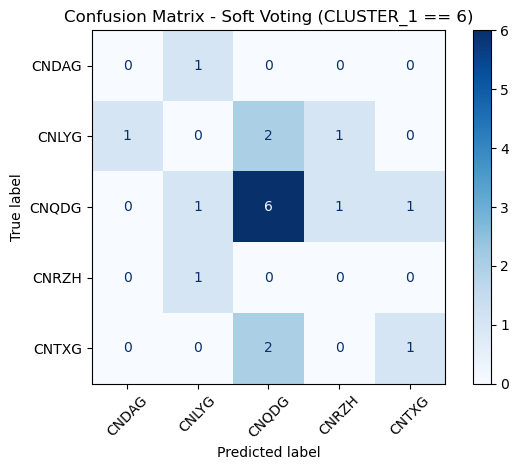

In [119]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import resample
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import (
    classification_report, accuracy_score, f1_score,
    confusion_matrix, ConfusionMatrixDisplay
)
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

# ===== 1. 데이터 불러오기 및 필터링 =====
df = pd.read_csv('./dataset/must_use_final.csv')
df["TIMESTAMP"] = pd.to_datetime(df["TIMESTAMP"])
df = df[df["CLUSTER_1"] == 6].copy()
df = df.sort_values("TIMESTAMP").reset_index(drop=True)

# ===== 2. 14시간 시점 기준 추출 (PORT_NAME까지 그룹핑) =====
time_based_data = []
max_gap = pd.Timedelta(minutes=10)

for (vsl_id, port), group in df.groupby(["VSL_ID", "PORT_NAME"]):
    group = group.sort_values("TIMESTAMP")
    if group.empty: continue
    start_time = group["TIMESTAMP"].min()
    target_time = start_time + pd.Timedelta(hours=14)
    time_diff = (group["TIMESTAMP"] - target_time).abs()
    closest_idx = time_diff.idxmin()
    if time_diff[closest_idx] <= max_gap:
        time_based_data.append(group.loc[closest_idx])

df_14h = pd.DataFrame(time_based_data).reset_index(drop=True)

# ===== 3. 라벨 인코딩 =====
le = LabelEncoder()
df_14h['CLUSTER_2'] = le.fit_transform(df_14h['PORT_NAME'])

# ===== 4. 학습/테스트 분리 =====
features = ['LAT', 'LON', 'COG', 'HEADING']
X = df_14h[features]
y = df_14h['CLUSTER_2']
X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.3, random_state=42
)
y_test_original = y_test.copy()  # 테스트 라벨 보존

# ===== 5. 클래스별 비율 기반 오버샘플링 =====
custom_ratios = {
    0: 1.0,   # CNQDG
    1: 1.5,   # CNLYG
    2: 1.5,   # CNTXG
    3: 2.5,   # CNDAG
    4: 3.0    # CNRZH
}

train_df = pd.concat([X_train, y_train], axis=1)
target = 'CLUSTER_2'
oversampled_rows = []

for label in train_df[target].unique():
    subset = train_df[train_df[target] == label]
    ratio = custom_ratios.get(label, 1.0)
    n_samples = int(len(subset) * ratio)
    
    if ratio > 1.0:
        upsampled = resample(subset, replace=True, n_samples=n_samples - len(subset), random_state=42)
        oversampled_rows.append(pd.concat([subset, upsampled]))
    else:
        oversampled_rows.append(subset)

train_oversampled = pd.concat(oversampled_rows).sample(frac=1, random_state=42).reset_index(drop=True)
X_train = train_oversampled[features]
y_train = train_oversampled[target]

np.save("datasets/X_train_c6_14hours.npy", X_train)
np.save("datasets/X_test_c6_14hours.npy", X_test)
np.save("datasets/y_train_c6_14hours.npy", y_train)
np.save("datasets/y_test_c6_14hours.npy", y_test)

# ===== 6. 모델 학습 =====
lr_model = LogisticRegression(max_iter=1000, class_weight='balanced')
lr_model.fit(X_train, y_train)

xgb_model = XGBClassifier(
    max_depth=3,
    learning_rate=0.05,
    n_estimators=100,
    use_label_encoder=False,
    eval_metric='mlogloss',
    random_state=42
)
xgb_model.fit(X_train, y_train)

# ===== 7. 앙상블 (Soft Voting) =====
voting_clf = VotingClassifier(
    estimators=[('lr', lr_model), ('xgb', xgb_model)],
    voting='soft'
)
voting_clf.fit(X_train, y_train)
voting_pred = voting_clf.predict(X_test)

# ===== 8. 성능 평가 및 과적합 진단 =====
train_pred = voting_clf.predict(X_train)

train_acc = accuracy_score(y_train, train_pred)
test_acc = accuracy_score(y_test_original, voting_pred)
gap = train_acc - test_acc
train_f1 = f1_score(y_train, train_pred, average='macro')
test_f1 = f1_score(y_test_original, voting_pred, average='macro')

print("📊 [Soft Voting 앙상블 성능]")
print(classification_report(y_test_original, voting_pred, target_names=le.classes_))
print(f"✅ Train Accuracy : {train_acc:.4f}")
print(f"✅ Test Accuracy  : {test_acc:.4f}")
print(f"🎯 Accuracy Gap   : {gap:.4f} {'⚠️ 과적합 의심' if gap > 0.1 else '✅ 과적합 아님'}")
print(f"🔍 Train F1 (macro): {train_f1:.4f}")
print(f"🔍 Test F1 (macro) : {test_f1:.4f}")

# ===== 9. 혼동 행렬 시각화 =====
cm = confusion_matrix(y_test_original, voting_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_)
disp.plot(cmap='Blues', xticks_rotation=45)
plt.title("Confusion Matrix - Soft Voting (CLUSTER_1 == 6)")
plt.tight_layout()
plt.show()


# 최선입니다...........................................................
# 암 쏘리. 베리베리 쏘리.
# 최선을 다햇어요. 여기에만 세시간을 붙잡혀잇엇어. ㅜㅜ

In [121]:
import joblib
import os

# 모델 저장
joblib.dump(voting_clf, 'model/port_c6_14hours.joblib')

# 인코더 저장
joblib.dump(le, 'model/encoder_c6_14hours.joblib')

print("✅ 모델과 인코더가 각각 저장되었습니다.")

✅ 모델과 인코더가 각각 저장되었습니다.


# 7번 군집

✅ 학습 및 테스트 데이터셋 저장 완료!


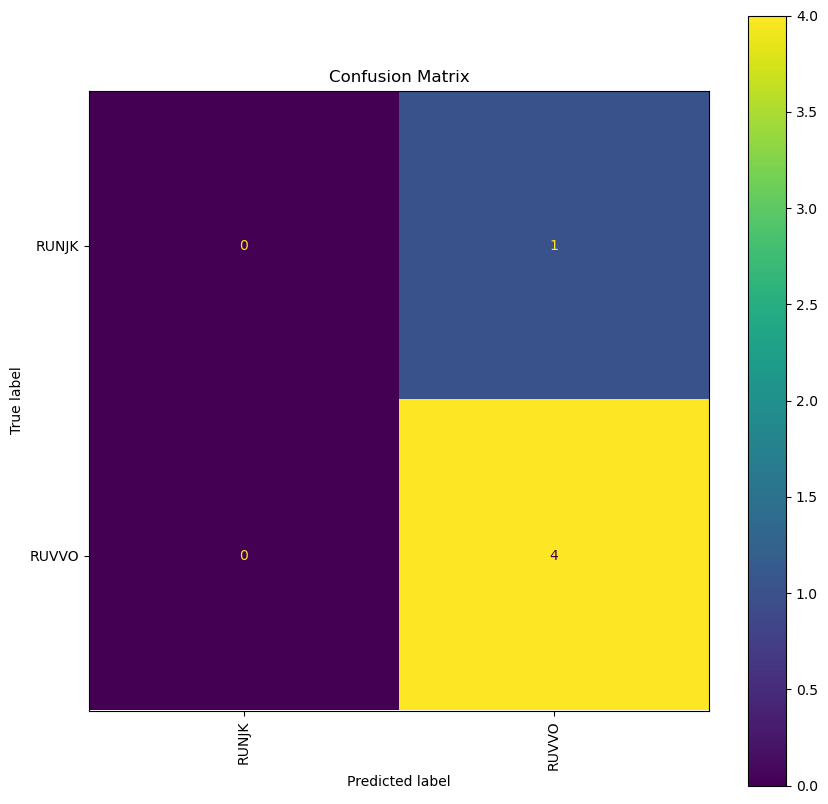


📊 [교차검증 및 과적합 점검 결과]
학습 정확도              : 0.9000
테스트 정확도            : 0.8000
정확도 차이              : 0.1000 과적합 위험 없음
교차검증 평균 정확도     : 0.8500 ± 0.1225
교차검증 F1 매크로 평균  : 0.6571
교차검증 정밀도 평균     : 0.6250

📄 [Classification Report]
              precision    recall  f1-score   support

       RUNJK       0.00      0.00      0.00         1
       RUVVO       0.80      1.00      0.89         4

    accuracy                           0.80         5
   macro avg       0.40      0.50      0.44         5
weighted avg       0.64      0.80      0.71         5



In [138]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import resample
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.metrics import classification_report, accuracy_score, f1_score, precision_score, confusion_matrix, ConfusionMatrixDisplay
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
import os

# ===== 1. 데이터 불러오기 및 CLUSTER_1 == 2 필터링 =====
df = pd.read_csv('./dataset/must_use_final.csv')
df["TIMESTAMP"] = pd.to_datetime(df["TIMESTAMP"])
df = df[df["CLUSTER_1"] == 7].copy() # 여기 수정
df = df.sort_values("TIMESTAMP").reset_index(drop=True)

# ===== 2. 14시간 시점 기준 추출 =====
time_based_data = []
max_gap = pd.Timedelta(minutes=10)

for (vsl_id, port), group in df.groupby(["VSL_ID", "PORT_NAME"]):
    group = group.sort_values("TIMESTAMP")
    if group.empty: continue
    start_time = group["TIMESTAMP"].min()
    target_time = start_time + pd.Timedelta(hours=14) # 여기 수정
    time_diff = (group["TIMESTAMP"] - target_time).abs()
    closest_idx = time_diff.idxmin()
    if time_diff[closest_idx] <= max_gap:
        time_based_data.append(group.loc[closest_idx])

df_14h = pd.DataFrame(time_based_data).reset_index(drop=True)


# ===== 2. 피처 및 라벨 인코딩 =====
features = ["LAT", "LON", "COG", "HEADING"]
X = df_14h[features]         # ✅ 수정
y = df_14h["PORT_NAME"]      # ✅ 수정
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# ===== 3. 학습/테스트 분리 =====
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, stratify=y_encoded, random_state=42
)

# ===== 4. 클래스별 오버샘플링 (Train만) =====
class_counts = pd.Series(y_train).value_counts()
max_count = class_counts.max()
minority_classes = class_counts[class_counts < max_count * 1.5].index

# 원하는 샘플링 비율 지정
sampling_ratios = {
    0: 2.0,
    1: 2.5,
    2: 1.0,
    3: 2.5
}

resampled_X = []
resampled_y = []

for label in minority_classes:
    subset_X = X_train[y_train == label]
    subset_y = y_train[y_train == label]
    
    n_samples = int(len(subset_X) * sampling_ratios.get(label, 1.0))
    
    up_X = resample(subset_X, replace=True, n_samples=n_samples, random_state=42)
    up_y = np.full(n_samples, label)
    
    resampled_X.append(up_X)
    resampled_y.append(up_y)

X_train_resampled = np.vstack(resampled_X)
y_train_resampled = np.hstack(resampled_y)

# ===== 5. 모델 정의 및 학습 (하이퍼파라미터 조정 포함) =====
rf = RandomForestClassifier(
    class_weight='balanced',
    n_estimators=50,
    max_depth=5,
    min_samples_leaf=5,
    random_state=42
)

xgb = XGBClassifier(
    n_estimators=50,
    max_depth=3,
    learning_rate=0.05,
    reg_alpha=0.5,
    reg_lambda=1.0,
    use_label_encoder=False,
    eval_metric='mlogloss',
    random_state=42
)

voting_clf = VotingClassifier(
    estimators=[('rf', rf), ('xgb', xgb)],
    voting='soft'
)

voting_clf.fit(X_train_resampled, y_train_resampled)

# ===== 6. 평가 =====
y_pred = voting_clf.predict(X_test)
report = classification_report(y_test, y_pred, target_names=le.classes_)

# ===== 7. 저장 =====

np.save("datasets/X_train_c7_14hours.npy", X_train_resampled)
np.save("datasets/X_test_c7_14hours.npy", X_test)
np.save("datasets/y_train_c7_14hours.npy", y_train_resampled)
np.save("datasets/y_test_c7_14hours.npy", y_test)
print("✅ 학습 및 테스트 데이터셋 저장 완료!")

# ===== 8. 교차검증 =====
acc_scores = cross_val_score(voting_clf, X_train, y_train, cv=5, scoring='accuracy')
f1_scores = cross_val_score(voting_clf, X_train, y_train, cv=5, scoring='f1_macro')
prec_scores = cross_val_score(voting_clf, X_train, y_train, cv=5, scoring='precision_macro')

# ===== 9. 과적합 점검 =====
train_score = voting_clf.score(X_train, y_train)
test_score = voting_clf.score(X_test, y_test)
gap = train_score - test_score

# ===== 10. Confusion Matrix 시각화 =====
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_)
fig, ax = plt.subplots(figsize=(10, 10))
disp.plot(ax=ax, xticks_rotation=90)
plt.title("Confusion Matrix")
plt.grid(False)
plt.show()

# ===== 11. 출력 =====
print("\n📊 [교차검증 및 과적합 점검 결과]")
print(f"학습 정확도              : {train_score:.4f}")
print(f"테스트 정확도            : {test_score:.4f}")
print(f"정확도 차이              : {gap:.4f} {'⚠️ 과적합 의심' if gap > 0.1 else '과적합 위험 없음'}")
print(f"교차검증 평균 정확도     : {acc_scores.mean():.4f} ± {acc_scores.std():.4f}")
print(f"교차검증 F1 매크로 평균  : {f1_scores.mean():.4f}")
print(f"교차검증 정밀도 평균     : {prec_scores.mean():.4f}")
print("\n📄 [Classification Report]")
print(report)


In [140]:
import joblib
import os

# 모델 저장
joblib.dump(voting_clf, 'model/port_c7_14hours.joblib')

# 인코더 저장
joblib.dump(le, 'model/encoder_c7_14hours.joblib')

print("✅ 모델과 인코더가 각각 저장되었습니다.")

✅ 모델과 인코더가 각각 저장되었습니다.
